### Generates a data base of responses for each trail for the single units. 

#### Run this notebook after creating the /PlaybackPkl files inside the site folder using PlotSpikeSortedCategoriesGUI.ipynb

#### You should only have to modify the rootPath in cell 2 for this notebook to work.


In [1]:
# Dependencies 
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pk
from scipy.stats import t
from sklearn.decomposition import PCA


### Set Paths
Note that it is assumed that you have data directory accessible from the rootPath

In [2]:
rootPath = '/Users/frederictheunissen/Code/songephys/'
dataPath = 'data/birds/'

birds = [
    os.path.basename(bird)
    for bird in sorted(glob.glob(os.path.join(rootPath+dataPath, "*")), key=os.path.getmtime, reverse=True)
    if (os.path.isdir(bird))]

In [3]:
birds = ['ZF7F', 'ZF6M', 'ZF5M', 'ZF4F']

### Functions

In [4]:
# These 3 z_score_stim functions could be combinned into 1.

def calc_zscore_stim(stimName):
    global dfRelTime
    
    rows = []
    # This loop finds all rows that match but there should only be one.
    for index, row in dfRelTime.iterrows():
        if row['file'] == stimName:
            rows.append(row)
    if (len(rows) != 1):
        print('Stimulus not found or too many')
        return 0.0, 1.0, 0
    
    # Choose one and only
    row = rows[0]
    
    # Calculates response diff for each stim
    spikeDiff = np.zeros(row['nTrials'])
    for it in range(row['nTrials']):
        spikeDiff[it] = np.sum((row['spikeTimes'][it] >= 0) & (row['spikeTimes'][it] < 0.5)) - np.sum((row['spikeTimes'][it] >= -0.5) & (row['spikeTimes'][it] < 0)) 
           
    # Calculate z-score and pvalue
    if (row['nTrials'] > 1) :
        sdiffSD = np.std(spikeDiff, ddof=1)
        if sdiffSD == 0:
            spikeDiff[0] += 1
            sdiffSD = np.std(spikeDiff, ddof=1)

        zscore = np.mean(spikeDiff)/sdiffSD
        if (zscore < 0.0):
            pvalue = (t.cdf(zscore*np.sqrt(row['nTrials']), row['nTrials']))*2.0
        else:
            pvalue = (1.0 - t.cdf(zscore*np.sqrt(row['nTrials']), row['nTrials']))*2.0
    else:
        zscore = 0
        pvalue = 1.0
        
    return zscore, pvalue, row['nTrials']

def calc_zscore_category(catName):
    global dfRelTime
    
    rows = []
    # This loop finds all rows that match but there should only be one.
    
    nTotal = 0
    for index, row in dfRelTime.iterrows():
        if row['call_type'] == catName:
            rows.append(row)
            nTotal += row['nTrials']
    if (nTotal == 0):
        return 0.0, 1.0, nTotal
    
    spikeDiff = np.zeros(nTotal)
    itot = 0
    for row in rows:
        for it in range(row['nTrials']):
            spikeDiff[itot] = np.sum((row['spikeTimes'][it] >= 0) & (row['spikeTimes'][it] < 0.5)) - np.sum((row['spikeTimes'][it] >= -0.5) & (row['spikeTimes'][it] < 0)) 
            itot += 1
            
    # Calculate z-score and pvalue
    if (nTotal > 1) :
        sdiffSD = np.std(spikeDiff, ddof=1)
        if sdiffSD == 0:
            spikeDiff[0] += 1
            sdiffSD = np.std(spikeDiff, ddof=1)

        zscore = np.mean(spikeDiff)/sdiffSD
        if (zscore < 0.0):
            pvalue = (t.cdf(zscore*np.sqrt(row['nTrials']), row['nTrials']))*2.0
        else:
            pvalue = (1.0 - t.cdf(zscore*np.sqrt(row['nTrials']), row['nTrials']))*2.0
    else:
        zscore = 0
        pvalue = 1.0
        
    return zscore, pvalue, nTotal


def calc_zscore_all():  
    global dfRelTime

    # Loop through all stims and trials.
    nTotal = 0
    for index, row in dfRelTime.iterrows():
        nTotal += row['nTrials']
            
    spikeDiff = np.zeros(nTotal)
    itot = 0
    for index, row in dfRelTime.iterrows():
        for it in range(row['nTrials']):        
            # Spike difference first 500 ms
            spikeDiff[itot] = np.sum((row['spikeTimes'][it] >= 0) & (row['spikeTimes'][it] < 0.5)) - np.sum((row['spikeTimes'][it] >= -0.5) & (row['spikeTimes'][it] < 0)) 
            itot += 1

    # Calculate z-score and pvalue
    if (nTotal > 1) :
        sdiffSD = np.std(spikeDiff, ddof=1)
        if sdiffSD == 0:
            spikeDiff[0] += 1   # Add a spike to generate SD
            sdiffSD = np.std(spikeDiff, ddof=1)
            
        zscore = np.mean(spikeDiff)/sdiffSD
        if (zscore < 0.0):
            pvalue = (t.cdf(zscore*np.sqrt(nTotal), nTotal))*2.0
        else:
            pvalue = (1.0 - t.cdf(zscore*np.sqrt(nTotal), nTotal))*2.0
    else: 
        zscore = 0
        pvalue = 1.0
        
    return zscore, pvalue, nTotal

    
def load_playbackPkl(playPklPath, playbackPkl):
    global unitInfo, dfRelTime
                
    # Load unitInfo and data frames 
    pklFile = playPklPath + playbackPkl
    try:
        fileIn = open(pklFile, 'rb')
        try:
            unitInfo = pk.load(fileIn)
            dfAbsTime = pk.load(fileIn)
            dfRelTime = pk.load(fileIn)
            fileIn.close()
        except:
            print('Empty file: ', pklFile)
    except OSError as err:
        print("OS error: {0}".format(err))

    
    return
               



### Loop through data a fist time and make summary data frame w results

In [7]:
dfDataBase = pd.DataFrame(columns=['bird', 'site', 'unit', 'stim', 'call', 'trial', 'R', 'z', 'PCPOS'])
itKDE_end = 1000    # Number of points in the KDE for PCs
itKDE_start = 500

kdeList = []

for bird in birds:    
    # Find sites
    sites = [ 
        os.path.basename(site)
        for site in glob.glob(os.path.join(rootPath+dataPath+bird+'/sites/', "*"))
    ]
    
    # Loop through sites
    for site in sites:
        playPklPath = rootPath + dataPath + bird + '/sites/' + site + '/PlaybackPkl/'
    
        # Set up list of Playback files available for this site
        playPkls = [ 
            os.path.basename(efile)
            for efile in glob.glob(playPklPath + '*.pkl')
        ]
        for playPkl in playPkls:
            load_playbackPkl(playPklPath, playPkl)
            
            # Select only single units.
            if unitInfo['SpikeSNR'] < 5.0:
                continue
                
            # Get a measure of auditory strength
            zTot, pTot, nTot = calc_zscore_all()
            
            # Select only units that have significant auditory responses
            if pTot > 0.01:
                continue
                               
            # Loop through call categories to get measure of call-type selectivity
            calls = dfRelTime['call_type'].unique()
            calls = calls[calls != None]    # Removing None (other stims)
            ncalls = len(calls)
            
            if (ncalls == 0) :        # This happens if there is data for the other stims..
                continue
            
            # Generate PCs and Variance
            # Estimate the number of trials and number of stims with 5 or more trials.
            # This code can be beautified using better pandas syntax
            
            # Counting the number of trials and of kdes
            nTotal = 0
            nKDE = 0
            for index, row in dfRelTime.iterrows():
                # Ignore stims that are not vocalizations
                if row['call_type'] == None:
                    continue
                nTotal += row['nTrials']
                if row['nTrials'] >=5: 
                    nKDE += 1
                    
            # Stuffing the arrays with the information        
            spikeDiff = np.zeros(nTotal)
            kdeArray = np.zeros((nKDE, itKDE_end-itKDE_start))                               
            itot = 0
            ikde = 0
            for index, row in dfRelTime.iterrows():
                # Ignore stims that are not vocalizations
                if row['call_type'] == None:
                    continue
                # Get the difference in spike counts.   
                for it in range(row['nTrials']):
                    spikeDiff[itot] = np.sum((row['spikeTimes'][it] >= 0) & (row['spikeTimes'][it] < 0.5)) - np.sum((row['spikeTimes'][it] >= -0.5) & (row['spikeTimes'][it] < 0)) 
                    itot += 1
                 # Get the KDE for the PC if more than 5 trials and data has spikes
                if row['nTrials'] >=5:
                    if np.sum(np.concatenate(row['spikeTimes'])):
                        kdeArray[ikde,:] = row['spikeKDE'][itKDE_start:itKDE_end]
                    ikde += 1
            
            spikeDiffSD = spikeDiff.std()
            if spikeDiffSD == 0.0:
                spikeDIffSD = 1/nTotal
                
            kdeList.append(kdeArray)
            
            # Loop through single trials            
            itot = 0
            for index, row in dfRelTime.iterrows():
                # Ignore stims that are not vocalizations
                if row['call_type'] == None:
                    continue                
                for it in range(row['nTrials']): 
                    dfDataBase = dfDataBase.append( {'bird': bird, 'site': site, 'unit': playPkl, 'stim': row['file'],  'call': row['call_type'], 'trial': it, 'R':spikeDiff[itot], 'z':spikeDiff[itot]/spikeDiffSD , 'PC': None}, ignore_index = True )
                    itot += 1
                

### Calculate and display PCs

In [8]:
# PCs of KDE
kdeAll = np.vstack(kdeList)

pcKDE = PCA(n_components=10)
kdePC = pcKDE.fit_transform(kdeAll)

print(pcKDE.explained_variance_ratio_)

[0.78408441 0.075058   0.05367179 0.03211374 0.02033035 0.01400611
 0.00887733 0.004878   0.00319739 0.00158132]


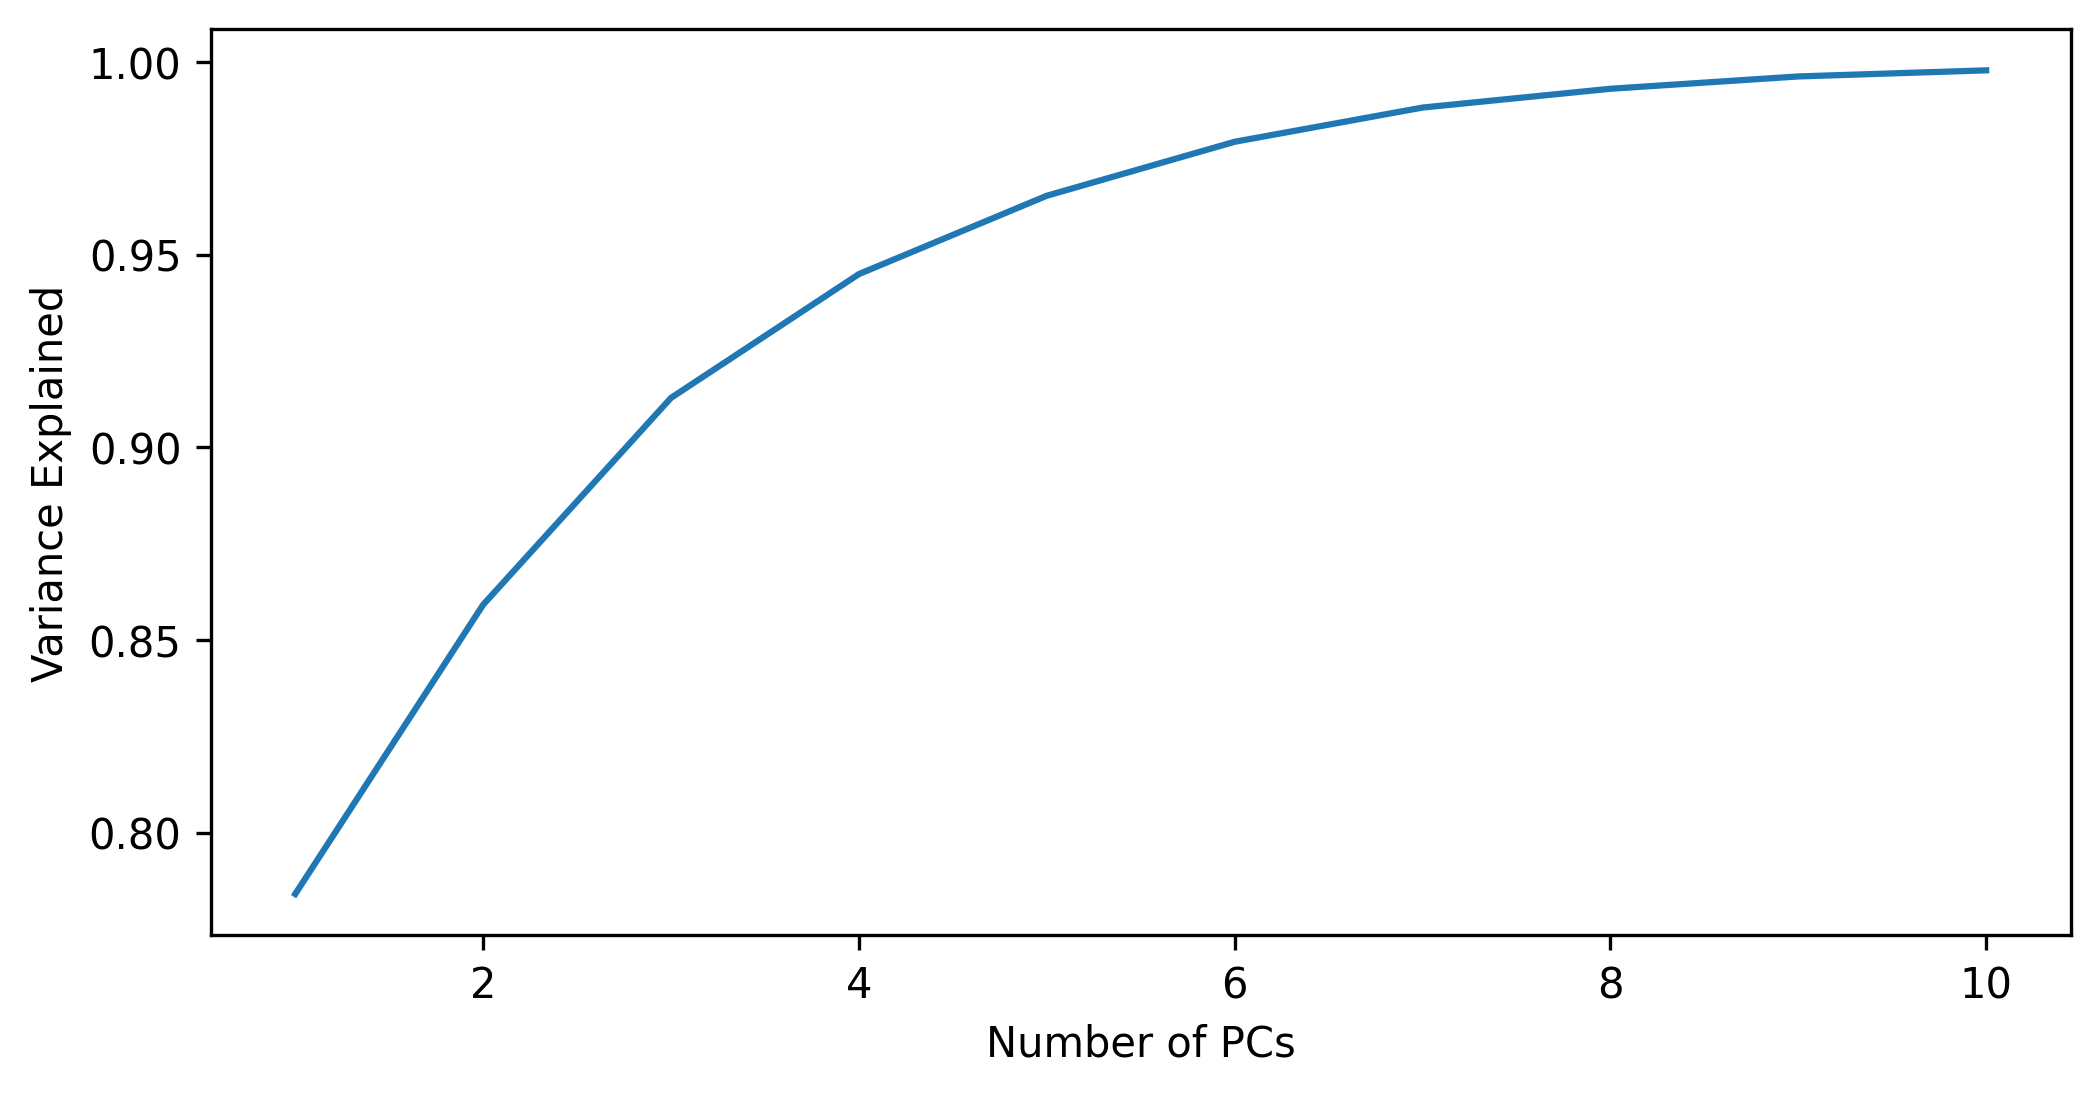

In [9]:
fig = plt.figure(figsize=(8,4), dpi = 300)

plt.plot(np.linspace(1,10, num=10), np.cumsum(pcKDE.explained_variance_ratio_))
plt.xlabel('Number of PCs')
plt.ylabel('Variance Explained')

plt.savefig('/Users/frederictheunissen/Desktop/PCAVarianceExplained.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


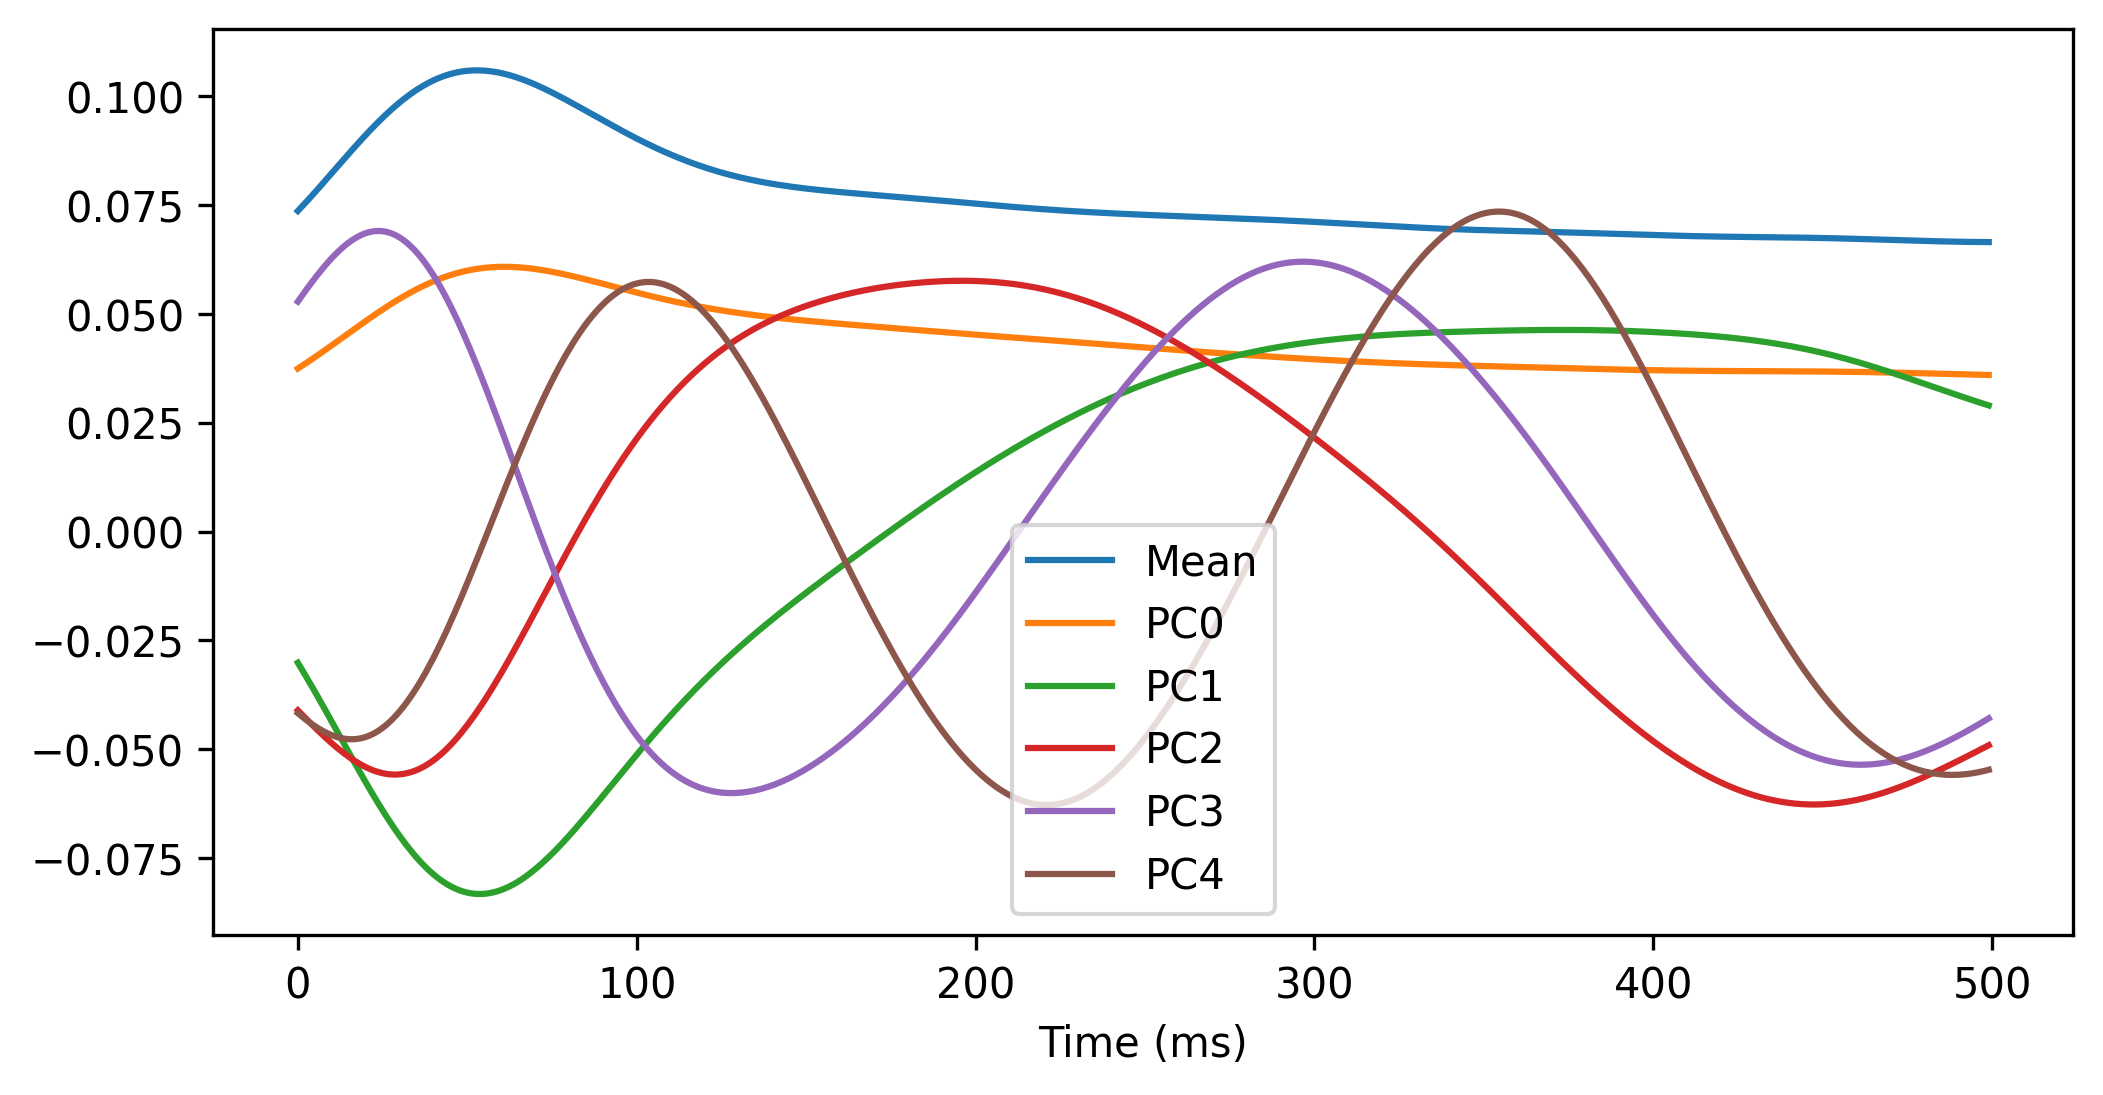

In [10]:

fig = plt.figure(figsize=(8,4), dpi=300)
plt.plot(pcKDE.mean_*.005, label='Mean')
plt.plot(pcKDE.components_[0,:], label='PC0')
plt.plot(pcKDE.components_[1,:], label='PC1')
plt.plot(pcKDE.components_[2,:], label='PC2')
plt.plot(pcKDE.components_[3,:], label='PC3')
plt.plot(pcKDE.components_[4,:], label='PC4')
plt.xlabel('Time (ms)')

plt.legend()

plt.savefig('/Users/frederictheunissen/Desktop/PCA5PCPOSs.eps')


### Loop through the data again to calculate the PC coefficients for each trial.

In [11]:
# Loop again through the data to fill in PC values
nPC = 5
pcList = []
for bird in birds:    
    # Find sites
    sites = [ 
        os.path.basename(site)
        for site in glob.glob(os.path.join(rootPath+dataPath+bird+'/sites/', "*"))
    ]
    
    # Loop through sites
    for site in sites:
        playPklPath = rootPath + dataPath + bird + '/sites/' + site + '/PlaybackPkl/'
    
        # Set up list of Playback files available for this site
        playPkls = [ 
            os.path.basename(efile)
            for efile in glob.glob(playPklPath + '*.pkl')
        ]
        for playPkl in playPkls:
            load_playbackPkl(playPklPath, playPkl)
            
            # Select only single units.
            if unitInfo['SpikeSNR'] < 5.0:
                continue
                
            # Get a measure of auditory strength
            zTot, pTot, nTot = calc_zscore_all()
            
            # Select only units that have significant auditory responses
            if pTot > 0.01:
                continue
                               
            # Loop through call categories to get measure of call-type selectivity
            calls = dfRelTime['call_type'].unique()
            calls = calls[calls != None]    # Removing None (other stims)
            ncalls = len(calls)
            
            if (ncalls == 0) :        # This happens if there is data for the other stims..
                continue
            
            # Calculate the PC coefficients.
            nTotal = 0
            nKDE = 0
            for index, row in dfRelTime.iterrows():
                # Ignore stims that are not vocalizations
                if row['call_type'] == None:
                    continue
                PCSum = np.zeros((1, nPC))
                for it in range(row['nTrials']) :
                    PCtrial = np.dot(pcKDE.components_[0:nPC,:], -pcKDE.mean_)   # This is how we remove the mean response before projecting into PC
                    for spikeTime in row['spikeTimes'][it]:
                        iMin = np.argmin(np.abs(row['tKDE']-spikeTime))
                        iMin -= itKDE_start
                        if iMin < (itKDE_end-itKDE_start):
                            PCtrial += 1000.0*pcKDE.components_[0:nPC,iMin]   # A single spike needs to be worth 1000.0 because our sampling rate of 1ms.
                    pcList.append(PCtrial)

            

In [12]:
# Store the PCs in the database
dfDataBase['PCPOS']=pcList

### Checking the values of the PCs

Trial: 0  PC: [-290.57250369  -85.57818868  -37.45146141   48.03614047  -23.83420448]
Trial: 1  PC: [-151.92137401 -141.33110049  -72.08135842  117.05345928   46.98276688]
Trial: 2  PC: [-312.00110467   32.85207618  -47.41765586  -61.74352397  -45.34501425]
Trial: 3  PC: [-348.6271471    -5.67501004   13.83342355   -8.22238047    2.06971103]
Trial: 4  PC: [ -86.86591318  292.8962937  -203.99639656   -6.66581826  195.38485187]
AVG PC: [[-297.49701066   23.29101767  -86.77836217   22.11446926   43.81452776]]
KDE PC: [-293.76305746   14.62358873  -29.66952747  -28.06638049   -4.91850692]


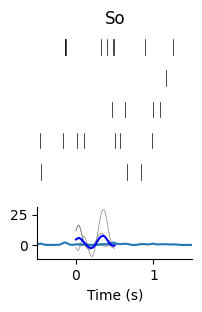

In [33]:
# Checking out the match between PC obtained per trial and from average KDE of PSTH
tInt = 1.0  # this value is 5.0 for Julie's data base

# Load a specific file - here we load the first one (the last one is empty - meaning it has no stims)
foundFlg = False
for bird in birds:    
    # Find sites
    sites = [ 
        os.path.basename(site)
        for site in glob.glob(os.path.join(rootPath+dataPath+bird+'/sites/', "*"))
    ]
    
    # Loop through sites
    for site in sites:
        playPklPath = rootPath + dataPath + bird + '/sites/' + site + '/PlaybackPkl/'
    
        # Set up list of Playback files available for this site
        playPkls = [ 
            os.path.basename(efile)
            for efile in glob.glob(playPklPath + '*.pkl')
        ]
        for playPkl in playPkls:
            load_playbackPkl(playPklPath, playPkl)
            
            # Select only single units.
            if unitInfo['SpikeSNR'] < 5.0:
                continue
                
            # Get a measure of auditory strength
            zTot, pTot, nTot = calc_zscore_all()
            
            # Select only units that have significant auditory responses
            if pTot > 0.01:
                continue
                               
            # Loop through call categories to get measure of call-type selectivity
            calls = dfRelTime['call_type'].unique()
            calls = calls[calls != None]    # Removing None (other stims)
            ncalls = len(calls)
            
            if (ncalls == 0) :        # This happens if there is data for the other stims..
                continue
                
            for index, row in dfRelTime.iterrows():
                # Ignore stims that are not vocalizations
                if row['call_type'] == None:
                    continue
            
                 # Get the KDE for the PC if more than 5 trials and data has spikes
                if row['nTrials'] >=5:
                    foundFlg = True
                    break
                
            # Found the first good one
            if foundFlg:
                break
        
        if foundFlg:
            break
    if foundFlg:
        break


# This code only works if you have a row defined from loop above.
PCSum = np.zeros((1, nPC))
for it in range(row['nTrials']) :
    PCtrial = np.dot(pcKDE.components_[0:nPC,:], -pcKDE.mean_)
    for spikeTime in row['spikeTimes'][it]:
        iMin = np.argmin(np.abs(row['tKDE']-spikeTime))
        iMin -= itKDE_start
        if iMin < (itKDE_end-itKDE_start):
            PCtrial += 1000.0*pcKDE.components_[0:nPC,iMin]
    print('Trial:', it, ' PC:', PCtrial)
    PCSum += PCtrial

print('AVG PC:', PCSum/row1['nTrials'])

print('KDE PC:', kdePC[0,0:nPC])



kdeNorm = row['spikeKDE'][itKDE_start:itKDE_end]*tInt/row['nTrials']            
fsamp = 1/(row['tKDE'][1]-row['tKDE'][0])

PCSum = np.zeros((1, nPC))
PCtrial = np.zeros((row['nTrials'], nPC))
for it in range(row['nTrials']) :
    PCtrial[it,:] = np.dot(pcKDE.components_[0:nPC,:], -pcKDE.mean_)   # This is how we remove the mean response before projecting into PC
    for spikeTime in row['spikeTimes'][it]:                            
        if spikeTime < -0.5:
            continue
        iMin = np.argmin(np.abs(row['tKDE']-spikeTime))
        if iMin < (itKDE_end-itKDE_start):
            PCtrial[it,:] += fsamp*pcKDE.components_[0:nPC,iMin]   # A single spike needs to be worth 1000.0 because our sampling rate of 1ms.
        else:
            break
    PCSum += PCtrial[it,:]   
                

kdeAVG = PCSum/row['nTrials']
            
fig = plt.figure(figsize=(2,3), dpi=100)
ax = fig.subplots(2,1, gridspec_kw={'height_ratios': [3,1]}, sharex= True)

for it in range(row['nTrials']):
    KDETrial = np.dot(PCtrial[it,:], pcKDE.components_[0:nPC,:]) + pcKDE.mean_
    ax[1].plot(row['tKDE'][itKDE_start:itKDE_end], KDETrial, color = '0.5', linewidth = 0.5)
    for spikeTime in row['spikeTimes'][it]:
        if spikeTime < -0.5:
            continue
        ax[0].plot([spikeTime, spikeTime], [10*it, 10*it +5], 'k-', linewidth=0.5)


ax[0].set_title(row['call_type'])
ax[0].set_xlim(-0.5, 1.5)
ax[0].set_axis_off()

# Reconstructed
ax[1].plot(row['tKDE'], row['spikeKDE']*tInt/row['nTrials'])

kdePC = pcKDE.transform(kdeNorm.reshape(1, -1))
KDERecon = np.dot(kdePC[0,0:nPC], pcKDE.components_[0:nPC,:]) + pcKDE.mean_
#ax[1].plot(row['tKDE'][0:1000], KDERecon, 'r')

KDERecon2 = np.dot(kdeAVG[0], pcKDE.components_[0:nPC,:]) + pcKDE.mean_
ax[1].plot(row['tKDE'][itKDE_start:itKDE_end], KDERecon2, 'b')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
plt.xlim(-0.5, 1.5)

plt.xlabel('Time (s)')
plt.show()
            


### Save results

In [23]:
# Temp save of results
outPath = rootPath+dataPath+'HerminaDataBasePCPOS.pkl'
fileOut = open(outPath,"wb")
pk.dump(dfDataBase, fileOut)
pk.dump(pcKDE, fileOut)
fileOut.close()